In [1]:
import numpy as np
import os
from pathlib import Path

import matplotlib.pyplot as plt
from keras.preprocessing import image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


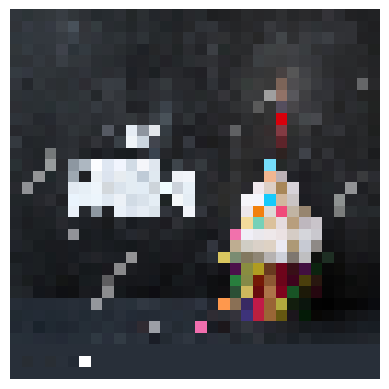

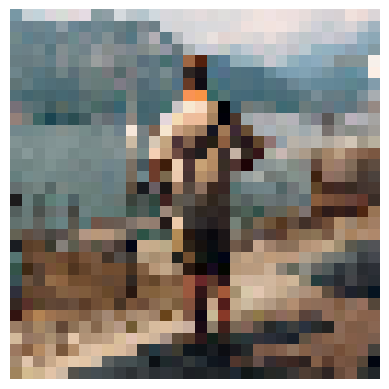

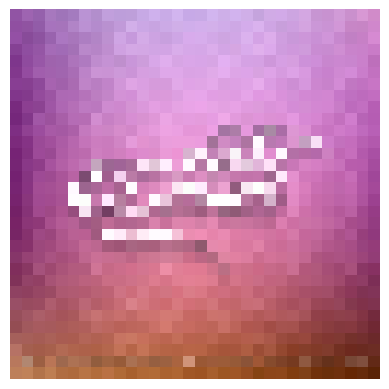

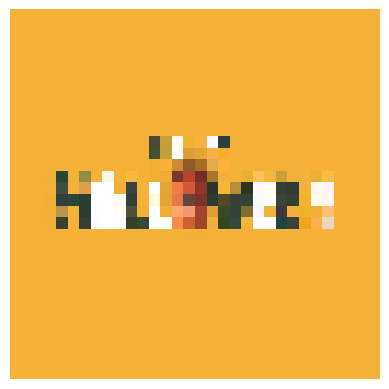

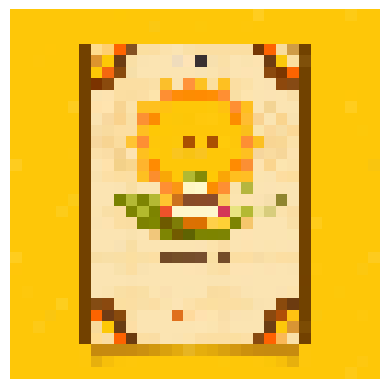

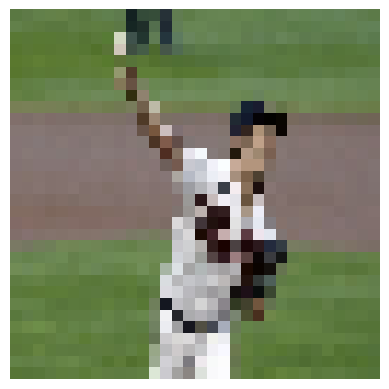

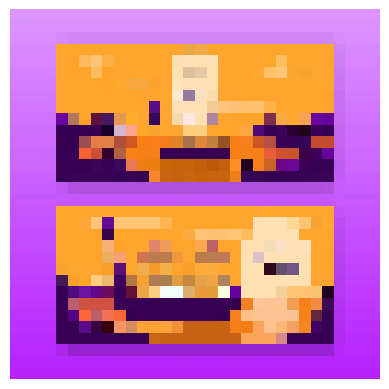

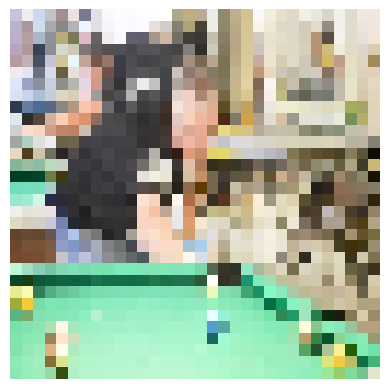

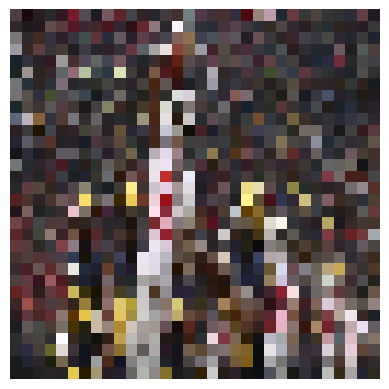

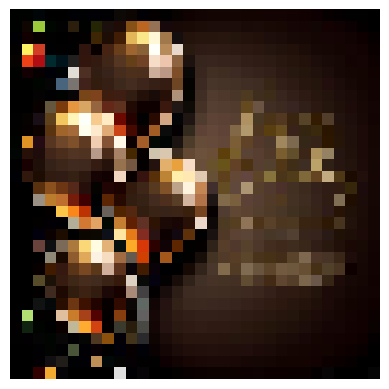

In [3]:
# Path to your dataset directory containing subdirectories for ham and spam images
p = Path("/content/drive/My Drive/DataSet_Work/Anaconda1/Train")
dirs = p.glob("*")
labels_dict = {'ham': 0, 'aspam': 1}

image_data = []
labels = []

# Load and process images
for folder_dir in dirs:
    label = str(folder_dir).split("/")[-1].lower()

    for img_path in folder_dir.glob("*.jpg"):
        img = image.load_img(img_path, target_size=(32,32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])

# Convert lists to numpy arrays
image_data = np.array(image_data, dtype='float32') / 255.0
labels = np.array(labels)

# Shuffle data
combined = list(zip(image_data, labels))
np.random.shuffle(combined)
image_data[:], labels[:] = zip(*combined)

# Display a few images (optional)
def drawImg(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Display a few images (optional)
for i in range(10):
    drawImg(image_data[i])


In [5]:
# SVM class for binary classification (ham vs. spam)
class SVM:
    def __init__(self, C=1.0):
        self.C = C
        self.W = 0
        self.b = 0

    def hingeLoss(self, W, b, X, Y):
        loss = 0.0
        loss += 0.5 * np.dot(W, W.T)

        m = X.shape[0]

        for i in range(m):
            ti = Y[i] * (np.dot(W, X[i].T) + b)
            loss += self.C * max(0, (1 - ti))

        return loss[0][0]

    def fit(self, X, Y, batch_size=50, learning_rate=0.001, maxItr=500):
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]

        n = learning_rate
        c = self.C

        # Initialize model parameters
        W = np.zeros((1, no_of_features))
        bias = 0

        # Training loop
        losses = []
        for i in range(maxItr):
            l = self.hingeLoss(W, bias, X, Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)

            # Batch Gradient Descent with random shuffling
            for batch_start in range(0, no_of_samples, batch_size):
                gradw = 0
                gradb = 0

                # Iterate over all examples in the mini batch
                for j in range(batch_start, batch_start + batch_size):
                    if j < no_of_samples:
                        i = ids[j]
                        ti =  Y[i] * (np.dot(W, X[i].T) + bias)

                        if ti > 1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c * Y[i] * X[i]
                            gradb += c * Y[i]

                # Update W, b
                W = W - n * W + n * gradw
                bias = bias + n * gradb

        self.W = W
        self.b = bias
        return W, bias, losses

# Function to prepare data pairs for SVM
def getDataPairForSVM(d1, d2):
    l1, l2 = d1.shape[0], d2.shape[0]
    samples = l1 + l2
    features = d1.shape[1]

    data_pair = np.zeros((samples, features))
    data_labels = np.zeros((samples,))

    data_pair[:l1, :] = d1
    data_pair[l1:, :] = d2

    data_labels[:l1] = -1  # class label for ham
    data_labels[l1:] = 1   # class label for spam

    return data_pair, data_labels

# Train an SVM for each pair of classes (ham vs. spam)
def trainSVMs(x, y):
    svm_classifiers = {}

    for i in range(number_of_classes):
        svm_classifiers[i] = {}
        for j in range(i + 1, number_of_classes):
            xpair, ypair = getDataPairForSVM(data[i], data[j])
            mySVM = SVM()
            wts, b, loss = mySVM.fit(xpair, ypair, learning_rate=0.00001, maxItr=1000)
            svm_classifiers[i][j] = (wts, b)

            plt.plot(loss)
            plt.xlabel("Iteration")
            plt.ylabel("Hinge Loss")
            plt.title(f"SVM Training Loss for classes {i} and {j}")
            plt.show()

    return svm_classifiers

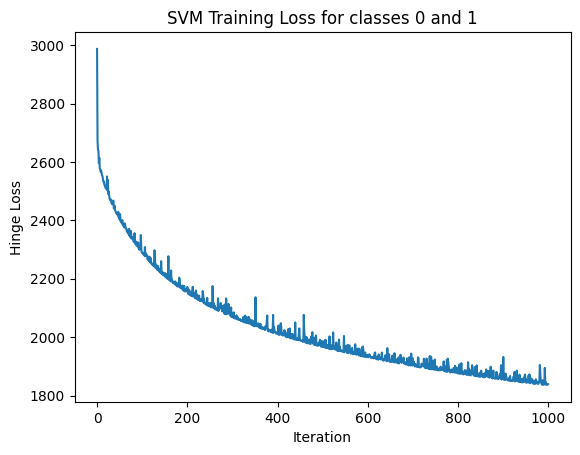

In [6]:
# Convert image_data to 1D array for SVM
M = image_data.shape[0]
image_data = image_data.reshape(M, -1)

# Number of classes (ham and spam)
number_of_classes = len(np.unique(labels))

# Function to organize data class-wise
def classWiseData(x, y):
    data = {}
    for i in range(number_of_classes):
        data[i] = []

    for i in range(x.shape[0]):
        data[y[i]].append(x[i])

    for k in data.keys():
        data[k] = np.array(data[k])

    return data

# Get data organized by class
data = classWiseData(image_data, labels)

# Train SVM classifiers
svm_classifiers = trainSVMs(image_data, labels)


In [7]:
# Function to predict class using SVM classifiers
def binaryPredict(x, w, b):
    z = np.dot(x, w.T) + b
    if z >= 0:
        return 1
    else:
        return -1

def predict(x):
    count = np.zeros((number_of_classes,))

    for i in range(number_of_classes):
        for j in range(i + 1, number_of_classes):
            w, b = svm_classifiers[i][j]

            # Take a majority prediction
            z = binaryPredict(x, w, b)

            if z == 1:
                count[j] += 1
            else:
                count[i] += 1

    final_prediction = np.argmax(count)
    return final_prediction

def accuracy(x, y):
    pred = []
    count = 0

    for i in range(x.shape[0]):
        prediction = predict(x[i])
        pred.append(prediction)
        if prediction == y[i]:
            count += 1

    return count / x.shape[0], pred

# Calculate accuracy on training data
acc, ypred = accuracy(image_data, labels)
print(f"Accuracy on training data: {acc}")


Accuracy on training data: 0.7164378975560763


In [8]:

test_p = Path("/content/drive/My Drive/DataSet_Work/Anaconda1/Test")
test_dirs = test_p.glob("*")

test_image_data = []
test_labels = []

# Load and process test images
for folder_dir in test_dirs:
    label = str(folder_dir).split("/")[-1].lower()

    for img_path in folder_dir.glob("*.jpg"):
        img = image.load_img(img_path, target_size=(32,32))
        img_array = image.img_to_array(img)
        test_image_data.append(img_array)
        test_labels.append(labels_dict[label])

# Convert lists to numpy arrays
test_image_data = np.array(test_image_data, dtype='float32') / 255.0
test_labels = np.array(test_labels)

# Reshape test_image_data to 1D array for SVM
M_test = test_image_data.shape[0]
test_image_data = test_image_data.reshape(M_test, -1)

Accuracy on test data: 0.55
Precision on test data: 0.44
Recall on test data: 0.75
F1 score on test data: 0.56
AUC on test data: 0.59
              precision    recall  f1-score   support

           0       0.74      0.44      0.55       434
           1       0.44      0.75      0.56       260

    accuracy                           0.55       694
   macro avg       0.59      0.59      0.55       694
weighted avg       0.63      0.55      0.55       694



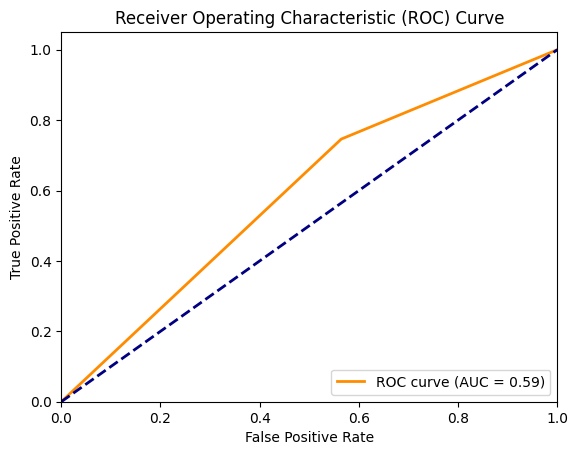

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report

def evaluate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', pos_label=1)  # pos_label=1 for 'spam'
    recall = recall_score(y_true, y_pred, average='binary', pos_label=1)  # pos_label=1 for 'spam'
    f1 = f1_score(y_true, y_pred, average='binary', pos_label=1)  # pos_label=1 for 'spam'

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    return accuracy, precision, recall, f1, fpr, tpr, roc_auc

# Predictions on test data
test_predictions = [predict(x) for x in test_image_data]

# Evaluate metrics including ROC curve
accuracy, precision, recall, f1, fpr, tpr, roc_auc = evaluate_metrics(test_labels, test_predictions)

print(f"Accuracy on test data: {accuracy:.2f}")
print(f"Precision on test data: {precision:.2f}")
print(f"Recall on test data: {recall:.2f}")
print(f"F1 score on test data: {f1:.2f}")
print(f"AUC on test data: {roc_auc:.2f}")

# Print classification report
print(classification_report(test_labels, test_predictions))

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()